## This script outputs the actual vs permuted eclip overlap fraction of the edit clusters

In [1]:
import os
cwd = os.getcwd()

main_dir = cwd
print(main_dir)

/tscc/lustre/ddn/scratch/q2liang/isSTAMP_publication_scripts/example_analysis_notebooks


In [2]:
import pandas as pd
from glob import glob
import pybedtools

shuffled_dir = main_dir + '/shuffled_confident_clusters/'
shuffled_dir_invivo = main_dir + '/../in_vivo_shuffled_confident_peaks/'
shuffled_peak_with_sequence_filepaths = glob(shuffled_dir + '*/*with_sequence.bed') + glob(shuffled_dir_invivo + '*/*with_sequence.bed')
len(shuffled_peak_with_sequence_filepaths)

120

In [3]:
rbfox2_to_plot_together_label = [ 'RBFOX2_INSCRIBE_PFA', 'Enzyme_Only_PFA', 'RBFOX2_ct_FOX2-APOBEC1_cleaned']
rbfox2_shuffles = [f for f in shuffled_peak_with_sequence_filepaths if f.split('/')[-1].split('_shuffle')[0] in rbfox2_to_plot_together_label]
len(rbfox2_shuffles)

60

### Load eCLIP file

In [4]:
import pybedtools
def load_eclip(filepath, l2fc_threshold=2, l10p_threshold=3):
    print(filepath)
    eclip_df = pd.read_csv(filepath,
                               sep='\t'
                               )

    total_columns = len(eclip_df.columns)
    
    eclip_df.columns=['chrom', 'start', 'end', 'l2fc', 'l10p', 'strand'] + [i for i in range(total_columns - 6)]
    print('\tBefore filter:', len(eclip_df))

    if 'region' in eclip_df.columns:
        eclip_df = eclip_df[~eclip_df.region.isin([
            'distintron500', 'proxintron500', 'distnoncoding_intron500', 'proxnoncoding_intron500', 'intergenic'
        ])]
        
    eclip_df = eclip_df[(eclip_df.l2fc > l2fc_threshold) & (eclip_df.l10p > l10p_threshold)]
    
    eclip_df['chrom'] = [i.split('chr')[1] for i in eclip_df.chrom]
    print('\tAfter filter: ', len(eclip_df))
    eclip_bed = pybedtools.BedTool.from_dataframe(eclip_df)

    return eclip_bed


# overall_path = '/projects/ps-yeolab3/ekofman/Hugo/Full_RBFOX2_and_SLBP/reference/hg38_eCLIPs'
q2liang_ref_path = '/tscc/lustre/ddn/scratch/q2liang/reference'

rbfox2_HEK_path = '{}/HEK293T_RBFOX2_reproducible_peaks.bed.hg38.v40.annotated'.format(q2liang_ref_path)

eclips = {
    'rbfox2_HEK': load_eclip(rbfox2_HEK_path)
}

/tscc/lustre/ddn/scratch/q2liang/reference/HEK293T_RBFOX2_reproducible_peaks.bed.hg38.v40.annotated
	Before filter: 7892
	After filter:  7892


### format conversion

In [5]:
conversion = {
    'chr1' : '1', 
    'chr10': '10', 
    'chr11': '11', 
    'chr12': '12', 
    'chr13': '13', 
    'chr14': '14', 
    'chr15': '15',
    'chr16': '16',
    'chr17': '17', 
    'chr18': '18', 
    'chr19': '19', 
    'chr2' : '2', 
    'chr20': '20', 
    'chr21': '21',
    'chr22': '22', 
    'chr3' : '3', 
    'chr4' : '4', 
    'chr5' : '5',
    'chr6' : '6', 
    'chr7' : '7', 
    'chr8' : '8', 
    'chr9' : '9',
    'chrM' : 'M',
    'chrX' : 'X', 
    'chrY' : 'Y'
}


def change(c):
    return conversion.get(c)



### Calculate actual overlaps 

In [6]:
peak_filepaths = sorted(glob(main_dir + '/confident_clusters/*_cleaned_confident*.bed')) 

actual_rbfox2 = []

for peak_filepath in peak_filepaths:    
    file_id = peak_filepath.split('/')[-1].split('_cleaned_confident')[0]
    # print('\t', file_id)
    if file_id in rbfox2_to_plot_together_label:  
        actual_rbfox2.append(peak_filepath)
    
peak_filepaths_invivo = sorted(glob(main_dir + '/../in_vivo_confident_peaks/*.bed')) 
for peak_filepath in peak_filepaths_invivo:    
    file_id = peak_filepath.split('/')[-1].split('.bed')[0]
    # print('\t', file_id)
    if file_id in rbfox2_to_plot_together_label:  
        actual_rbfox2.append(peak_filepath)

actual_rbfox2

['/tscc/lustre/ddn/scratch/q2liang/isSTAMP_publication_scripts/example_analysis_notebooks/confident_clusters/Enzyme_Only_PFA_cleaned_confident_clusters.bed',
 '/tscc/lustre/ddn/scratch/q2liang/isSTAMP_publication_scripts/example_analysis_notebooks/confident_clusters/RBFOX2_INSCRIBE_PFA_cleaned_confident_clusters.bed',
 '/tscc/lustre/ddn/scratch/q2liang/isSTAMP_publication_scripts/example_analysis_notebooks/../in_vivo_confident_peaks/RBFOX2_ct_FOX2-APOBEC1_cleaned.bed']

In [8]:
from collections import defaultdict

def calculate_bed_intersection_fraction(stamp_bed, eclip_bed):
    intersection = stamp_bed.intersect(eclip_bed, s=True, u=True)
    fraction_overlapped_by_eclip = len(intersection)/len(stamp_bed)
    return fraction_overlapped_by_eclip
rbfox2_actual_intersection_values = defaultdict(lambda:{})

for rbfox2_file in actual_rbfox2:
    print(rbfox2_file)
    if 'in_vivo' in rbfox2_file:
        rbfox2_label = rbfox2_file.split('/')[-1].split('.bed')[0]
        
    if 'in_vivo' not in rbfox2_file:
        rbfox2_label = rbfox2_file.split('/')[-1].split('_cleaned_confident')[0]

    rbfox2_df = pd.read_csv(rbfox2_file, sep='\t', names = ['chrom', 'start', 'end', 'score1', 'score2', 'strand', 'region'])
    rbfox2_df['chrom'] = rbfox2_df.chrom.astype(str).apply(change)
    print(len(rbfox2_df))
    print()
    rbfox2_bed = pybedtools.BedTool.from_dataframe(rbfox2_df)


    for eclip_comparison in ['rbfox2_HEK']:
        rbfox2_actual_intersection_values[rbfox2_label][eclip_comparison] = calculate_bed_intersection_fraction(rbfox2_bed, 
                                                                                                                eclips.get(eclip_comparison))

/tscc/lustre/ddn/scratch/q2liang/isSTAMP_publication_scripts/example_analysis_notebooks/confident_clusters/Enzyme_Only_PFA_cleaned_confident_clusters.bed
1678

/tscc/lustre/ddn/scratch/q2liang/isSTAMP_publication_scripts/example_analysis_notebooks/confident_clusters/RBFOX2_INSCRIBE_PFA_cleaned_confident_clusters.bed
2970

/tscc/lustre/ddn/scratch/q2liang/isSTAMP_publication_scripts/example_analysis_notebooks/../in_vivo_confident_peaks/RBFOX2_ct_FOX2-APOBEC1_cleaned.bed
1893



In [9]:
actual_rbfox2_intersection_df = pd.DataFrame(rbfox2_actual_intersection_values)
actual_rbfox2_intersection_df.transpose()

,rbfox2_HEK
Enzyme_Only_PFA,0.009535
RBFOX2_INSCRIBE_PFA,0.087542
RBFOX2_ct_FOX2-APOBEC1_cleaned,0.011094


### Calculate the overlaps of the shuffled peaks

In [10]:
from collections import defaultdict 

overlaps_for_rbfox2_shuffles = defaultdict(lambda:defaultdict(lambda:[]))

for shuffle in rbfox2_shuffles:
    if 'in_vivo' in shuffle:
        rbfox2_label = shuffle.split('/')[-2]
        print(rbfox2_label)
        stamp_shuffle_bed = pybedtools.BedTool.from_dataframe(pd.read_csv(shuffle, sep='\t')[['chrom', 'start', 'end', 'strand', 'strand', 'strand']])
        print(len(stamp_shuffle_bed))
        print()

    if 'in_vivo' not in shuffle:
        rbfox2_label = shuffle.split('/')[-2]
        print(rbfox2_label)
        shuffle_df = pd.read_csv(shuffle, sep='\t', header = 0)[['chrom', 'start', 'end', 'strand', 'strand', 'strand']]
        shuffle_df['chrom'] = shuffle_df.chrom.astype(str).apply(change)
        print()
        stamp_shuffle_bed = pybedtools.BedTool.from_dataframe(shuffle_df)
        print(len(stamp_shuffle_bed))

    
    for eclip_comparison in ['rbfox2_HEK']:
        overlaps_for_rbfox2_shuffles[rbfox2_label][eclip_comparison].append(calculate_bed_intersection_fraction(stamp_shuffle_bed,
                                                                                                           eclips.get(eclip_comparison)))

Enzyme_Only_PFA

1492
Enzyme_Only_PFA

1492
Enzyme_Only_PFA

1492
Enzyme_Only_PFA

1492
Enzyme_Only_PFA

1492
Enzyme_Only_PFA

1492
Enzyme_Only_PFA

1492
Enzyme_Only_PFA

1492
Enzyme_Only_PFA

1492
Enzyme_Only_PFA

1492
Enzyme_Only_PFA

1492
Enzyme_Only_PFA

1492
Enzyme_Only_PFA

1492
Enzyme_Only_PFA

1492
Enzyme_Only_PFA

1492
Enzyme_Only_PFA

1492
Enzyme_Only_PFA

1492
Enzyme_Only_PFA

1492
Enzyme_Only_PFA

1492
Enzyme_Only_PFA

1492
RBFOX2_INSCRIBE_PFA

2709
RBFOX2_INSCRIBE_PFA

2709
RBFOX2_INSCRIBE_PFA

2709
RBFOX2_INSCRIBE_PFA

2709
RBFOX2_INSCRIBE_PFA

2709
RBFOX2_INSCRIBE_PFA

2709
RBFOX2_INSCRIBE_PFA

2709
RBFOX2_INSCRIBE_PFA

2709
RBFOX2_INSCRIBE_PFA

2709
RBFOX2_INSCRIBE_PFA

2709
RBFOX2_INSCRIBE_PFA

2709
RBFOX2_INSCRIBE_PFA

2709
RBFOX2_INSCRIBE_PFA

2709
RBFOX2_INSCRIBE_PFA

2709
RBFOX2_INSCRIBE_PFA

2709
RBFOX2_INSCRIBE_PFA

2709
RBFOX2_INSCRIBE_PFA

2709
RBFOX2_INSCRIBE_PFA

2709
RBFOX2_INSCRIBE_PFA

2709
RBFOX2_INSCRIBE_PFA

2709
RBFOX2_ct_FOX2-APOBEC1_cleaned
1895

RBF

In [11]:
calculate_bed_intersection_fraction_df = pd.DataFrame(overlaps_for_rbfox2_shuffles)
calculate_bed_intersection_fraction_df.transpose()

,rbfox2_HEK
Enzyme_Only_PFA,"[0.006032171581769437, 0.006702412868632708, 0..."
RBFOX2_INSCRIBE_PFA,"[0.03617571059431524, 0.03949796973052787, 0.0..."
RBFOX2_ct_FOX2-APOBEC1_cleaned,"[0.005804749340369393, 0.0036939313984168864, ..."


### Plotting

In [12]:

values_list_rbfox2_HEK = []
labels_list_rbfox2_HEK = []


for label in rbfox2_to_plot_together_label:
    print(label)
    if label in overlaps_for_rbfox2_shuffles.keys():
        df_for_label = pd.DataFrame(overlaps_for_rbfox2_shuffles.get(label))
        values_list_rbfox2_HEK.append(df_for_label['rbfox2_HEK'].tolist())

        labels_list_rbfox2_HEK.append(label)

    else:
        print('{} not present'.format(label))
        
for k,v in rbfox2_actual_intersection_values.items():
    rbfox2_actual_intersection_values[k] = v
        

RBFOX2_INSCRIBE_PFA
Enzyme_Only_PFA
RBFOX2_ct_FOX2-APOBEC1_cleaned


In [13]:
import subprocess
figures_directory = main_dir + '/figures_actual_vs_shuffle/'
subprocess.run(["mkdir",figures_directory])


CompletedProcess(args=['mkdir', '/tscc/lustre/ddn/scratch/q2liang/isSTAMP_publication_scripts/example_analysis_notebooks/figures_actual_vs_shuffle/'], returncode=1)

In [14]:
label_to_legend_dict = {
'RBFOX2_INSCRIBE_PFA':'RBFOX2 INSCRIBE\n(PFA-fixed)',
'Enzyme_Only_PFA':'INSCRIBE Enzyme-Only\n(PFA-fixed)',
'RBFOX2_ct_FOX2-APOBEC1_cleaned': 'RBFOX2 in cell STAMP'
}


legends = [label_to_legend_dict.get(i) for i in rbfox2_to_plot_together_label]

print(legends)

['RBFOX2 INSCRIBE\n(PFA-fixed)', 'INSCRIBE Enzyme-Only\n(PFA-fixed)', 'RBFOX2 in cell STAMP']


/tscc/lustre/ddn/scratch/q2liang/isSTAMP_publication_scripts/example_analysis_notebooks/figures_actual_vs_shuffle//RBFOX2_eCLIP
RBFOX2_INSCRIBE_PFA
0.08754208754208755
0.03935031376891842
2.2246858832224685
Enzyme_Only_PFA
0.009535160905840286
0.006434316353887399
1.481922924116011
RBFOX2_ct_FOX2-APOBEC1_cleaned
0.011093502377179081
0.005303430079155674
2.0917599009705827
[2.2246858832224685, 1.481922924116011, 2.0917599009705827]


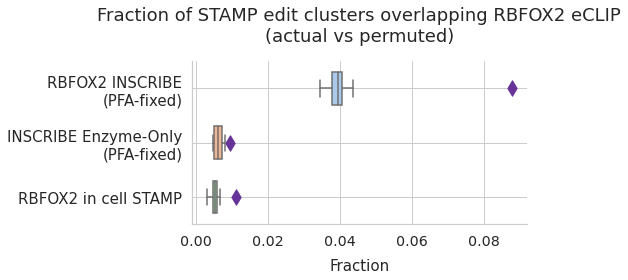

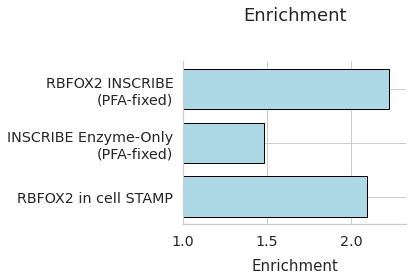

In [15]:
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np
plt.rcParams['pdf.fonttype'] = 42

plot_group = 'RBFOX2_FM-fix-compare'

for labels, values, category, title in zip(
    [labels_list_rbfox2_HEK], 
    [values_list_rbfox2_HEK],
    ['rbfox2_HEK'],
    ['RBFOX2 eCLIP'],
):
        
        filename = title.replace('-', '_').replace(' ', '_').replace(',', '')
        filename = '{}/{}'.format(figures_directory, filename)
        print(filename)
        
        custom_params = {"axes.spines.right": False, "axes.spines.top": False}
        sns.set_theme(style="whitegrid", rc=custom_params, font_scale=1.3)

        plt.figure(figsize=(6, 3))

        tick_labels = legends
        range_array= [i for i in range(len(legends))]

        a = sns.boxplot(data = values, orient = 'h', palette='pastel', showfliers = False, width= 0.6)
        a.set_yticklabels(legends, ha='right', fontsize = 15)
        a.yaxis.grid(True)
        a.xaxis.grid(True)

        # a.set(ylim=(0, 0.05))

        b = plt.scatter([rbfox2_actual_intersection_values.get(l).get(category) for l in rbfox2_to_plot_together_label], range_array, marker = 'd', s = 120, color = 'rebeccapurple')
        # b = sns.scatterplot(data = [rbfox2_actual_intersection_values.get(l).get(category) for l in rbfox2_to_plot_together_label], orient='h', marker = 'd', s = 200, color = 'rebeccapurple')

        plt.xlabel("Fraction", labelpad=10, fontsize = 15 )
        plt.title("Fraction of STAMP edit clusters overlapping {}\n(actual vs permuted)".format(title), pad=20, fontsize = 18)
        # c = plt.yticks(range_array, tick_labels)
        
        # plt.savefig('{}-box-color-{}.png'.format(filename,plot_group), bbox_inches='tight', dpi = 300)
        # plt.savefig('{}-box-color-{}.svg'.format(filename,plot_group), bbox_inches='tight')
        # plt.savefig('{}-box-color-{}.pdf'.format(filename,plot_group), bbox_inches='tight')

        motif_odds_ratios = {}
        for label, peak_set in zip(labels, values):
            permuted_val = np.mean(peak_set)
            actual_val = rbfox2_actual_intersection_values.get(label).get(category)
            print(label)
            print(actual_val)
            print(permuted_val)
            print(actual_val/permuted_val)
            motif_odds_ratios[label] = actual_val/permuted_val
            

        ordered_motif_ors = []
        for o in rbfox2_to_plot_together_label:
            ordered_motif_ors.append(motif_odds_ratios.get(o))
        print(ordered_motif_ors)
        
        plt.figure(figsize=(4, 3))
        plt.barh(legends, ordered_motif_ors, color='lightblue', edgecolor = 'black', height = 0.75)
    
        min_val = np.min(ordered_motif_ors)
        max_val = np.max(ordered_motif_ors)

        plt.gca().invert_yaxis()

        plt.xlim(1, max_val + 0.1)
        plt.title("Enrichment\n" , pad=20, fontsize = 18)
        plt.xlabel("Enrichment", labelpad=10, fontsize = 15)


        
        # plt.savefig('{}-enrich-color-{}.png'.format(filename,plot_group), bbox_inches='tight', dpi = 300)
        # plt.savefig('{}-enrich-color-{}.svg'.format(filename,plot_group), bbox_inches='tight')
        # plt.savefig('{}-enrich-color-{}.pdf'.format(filename,plot_group), bbox_inches='tight')


In [16]:
motif_odds_ratios

{'RBFOX2_INSCRIBE_PFA': 2.2246858832224685,
 'Enzyme_Only_PFA': 1.481922924116011,
 'RBFOX2_ct_FOX2-APOBEC1_cleaned': 2.0917599009705827}

In [17]:
import numpy as np
from scipy import stats

actual_dict =  list(actual_rbfox2_intersection_df.transpose().to_dict().items())[0][1]

shuffle_dict = list(calculate_bed_intersection_fraction_df.transpose().to_dict().items())[0][1]



for k,v in shuffle_dict.items():
    print(k)
    mean = np.mean(v)
    std = np.std(v)
    zscore = (actual_dict.get(k) - mean) / std 
    print(zscore)


Enzyme_Only_PFA
1.9144427992842377
RBFOX2_INSCRIBE_PFA
19.583706482532257
RBFOX2_ct_FOX2-APOBEC1_cleaned
5.453807090186958
